# Bootstrap Current Self-Consistency

This tutorial demonstrates how to optimize a quasi-symmetric equilibrium to have a self-consistent bootstrap current profile. 
This is performed by minimizing the difference between the toroidal currents $\langle J \cdot B \rangle$ computed from the MHD equilibrium and from the Redl formula. 
The Redl formula is only valid in the limit of perfect quasi-symmetry, so this procedure will not work for other configurations that are not quasi-symmetric. 

There are two methods that can be used, and both will be shown: 

1. Optimize the current profile for self-consistency
2. Iteratively solve the equilibrium with new current profiles

These methods should be equivalent, although one might be faster than the other depending on the particular problem. 

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

If you have access to a GPU, uncomment the following two lines before any DESC or JAX related imports. You should see about an order of magnitude speed improvement with only these two lines of code!

In [2]:
# from desc import set_device
# set_device("gpu")

As mentioned in [DESC Documentation on performance tips](https://desc-docs.readthedocs.io/en/latest/performance_tips.html), one can use compilation cache directory to reduce the compilation overhead time. Note: One needs to create `jax-caches` folder manually.

In [3]:
# import jax

# jax.config.update("jax_compilation_cache_dir", "../jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [4]:
import numpy as np

np.set_printoptions(linewidth=np.inf)
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 14

from desc.compat import rescale
from desc.equilibrium import EquilibriaFamily
from desc.examples import get
from desc.grid import LinearGrid
from desc.objectives import (
    BootstrapRedlConsistency,
    FixAtomicNumber,
    FixBoundaryR,
    FixBoundaryZ,
    FixCurrent,
    FixElectronDensity,
    FixElectronTemperature,
    FixIonTemperature,
    FixPsi,
    ForceBalance,
    ObjectiveFunction,
)
from desc.plotting import plot_1d
from desc.profiles import PowerSeriesProfile, SplineProfile

As an example, we will reproduce the QA results from [Landreman et al. (2022)](https://doi.org/10.1063/5.0098166). 

We will start with the "precise QA" example equilibrium, scaled to the ARIES-CS reactor size. 

In [5]:
eq0 = get("precise_QA")
eq0 = rescale(eq0, L=("R0", 10), B=("B0", 5.86))

This equilibrium has the vacuum profiles $p = 0 ~\text{Pa}$ and $\frac{2\pi}{\mu_0} I = 0 ~\text{A}$. 
Calculating the bootstrap current requires knowledge of the temperature and density profiles for each species in the plasma. 
We replace the pressure profile with the following kinetic profiles corresponding to $\langle\beta\rangle=2.5\%$: 

$n_e = n_i = 2.38\times10^{20} (1 - \rho^{10}) ~\text{m}^{-3}$

$T_e = T_i = 9.45\times10^{3} (1 - \rho^{2}) ~\text{eV}$

The temperature profiles must be given for both ions and electrons, but only the electron density profile is specified. 
The ion density profile is given by the effective atomic number $Z_{eff}$ as $n_i = n_e / Z_{eff}$. 
The plasma pressure will then be computed as 

$p = e (n_e T_e + n_i T_i)$.

In [6]:
eq0.pressure = None  # must remove the pressure profile before setting kinetic profiles
eq0.atomic_number = PowerSeriesProfile([1])
eq0.electron_density = PowerSeriesProfile(params=[1, -1], modes=[0, 10]) * 2.38e20
eq0.electron_temperature = PowerSeriesProfile(params=[1, -1], modes=[0, 2]) * 9.45e3
eq0.ion_temperature = PowerSeriesProfile(params=[1, -1], modes=[0, 2]) * 9.45e3
# the existing current profile is the vacuum case eq0.current = PowerSeriesProfile([0])

We need to re-solve the equilibrium force balance with the new profiles. 

In [7]:
eq0, _ = eq0.solve(objective="force", optimizer="lsq-exact", verbose=3)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 920 ms
Timer: Objective build = 1.54 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed current
Building objective: fixed electron density
Building objective: fixed electron temperature
Building objective: fixed ion temperature
Building objective: fixed atomic number
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 634 ms
Timer: LinearConstraintProjection build = 3.45 sec
Number of parameters: 856
Number of objectives: 5346
Timer: Initializing the optimization = 5.65 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1  

Now we have our initial equilibrium, which does not have a self-consistent bootstrap current: 

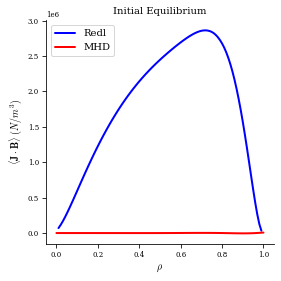

In [8]:
fig, ax = plot_1d(eq0, "<J*B> Redl", linecolor="b", lw=2, label="Redl")
fig, ax = plot_1d(eq0, "<J*B>", linecolor="r", lw=2, label="MHD", ax=ax)
ax.legend(loc="best")
ax.set_title("Initial Equilibrium");

We need to create a grid on which to evaluate the boootstrap current self-consistency. 
The bootstrap current is a radial profile, but the grid must have finite poloidal and toroidal resolution to accurately compute flux surface quantities. 
The Redl formula is undefined where the kinetic profiles vanish, so in our example we do not include points at $\rho=0$ or $\rho=1$. 

In [9]:
grid = LinearGrid(
    M=eq0.M_grid,
    N=eq0.N_grid,
    NFP=eq0.NFP,
    sym=eq0.sym,
    rho=np.linspace(1 / eq0.L_grid, 1, eq0.L_grid) - 1 / (2 * eq0.L_grid),
)

Our current profile will be represented as a power series of the form: 

$I = c_0 + c_1 \rho + c_2 \rho^2 + \mathcal{O}(\rho^3)$

Physically, the current should vanish on the magnetic axis so $c_0 = 0$. 
And in order for the MHD equilibrium to be analytic, it should scale as $\mathcal{O}(\rho^2)$ near the magnetic axis so $c_1 = 0$ also. 
However, the Redl bootstrap current formula scales as $\mathcal{O}(\sqrt{\rho})$ near the magnetic axis. 
This is incorrect, because the drift-kinetic equation from the Redl formula does not account for finite orbit width effects that become important near the axis. 

Typically, we use even power series with `sym=True` for all equilibrium profiles to give the desired analycity conditions. 
For bootstrap current optimizations, it is recommended to use the full power series with `sym=False` while also enforcing $c_0 = c_1 = 0$. 
This prevents getting good self-consistency near the magnetic axis, but allows for good agreement throughout the rest of the plasma volume and results in high quality equilibria overall. 


In [10]:
eq0.current = PowerSeriesProfile(np.zeros((eq0.L + 1,)), sym=False)

### 1. Optimization

In this method, we will optimize the current profile to minimize the self-consistency errors evaluated by the `BootstrapRedlConsistency` objective. 
This objective requires the helicity, which for QA is $(M, N) = (1, 0)$. 

In this example we will only optimize the current profile, so all other profiles and the plasma boundary are constrained to be fixed. 
It is recommended to use a very small value for `gtol` when optimizing the bootstrap current. 

In [11]:
eq1 = eq0.copy()

In [12]:
objective = ObjectiveFunction(
    BootstrapRedlConsistency(eq=eq1, grid=grid, helicity=(1, 0)),
)
constraints = (
    FixAtomicNumber(eq=eq1),
    FixBoundaryR(eq=eq1),
    FixBoundaryZ(eq=eq1),
    FixCurrent(eq=eq1, indices=[0, 1]),  # fix c_0=c_1=0 current profile coefficients
    FixElectronDensity(eq=eq1),
    FixElectronTemperature(eq=eq1),
    FixIonTemperature(eq=eq1),
    FixPsi(eq=eq1),
    ForceBalance(eq=eq1),
)
eq1, _ = eq1.optimize(
    objective=objective,
    constraints=constraints,
    optimizer="proximal-lsq-exact",
    maxiter=10,
    verbose=3,
)

Building objective: Bootstrap current self-consistency (Redl)
Precomputing transforms
Timer: Precomputing transforms = 934 ms
Timer: Objective build = 1.43 sec
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 47.4 ms
Timer: Objective build = 62.6 ms
Timer: Objective build = 1.19 ms
Timer: Eq Update LinearConstraintProjection build = 2.44 sec
Timer: Proximal projection build = 4.66 sec
Building objective: fixed atomic number
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed current
Building objective: fixed electron density
Building objective: fixed electron temperature
Building objective: fixed ion temperature
Building objective: fixed Psi
Timer: Objective build = 211 ms
Timer: LinearConstraintProjection build = 1.73 sec
Number of parameters: 7
Number of objectives: 16
Timer: Initializing the optimization = 6.63 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost re

When plotting the bootstrap current profiles, we see the MHD equilibrium now has very good agreement with the Redl formula. 

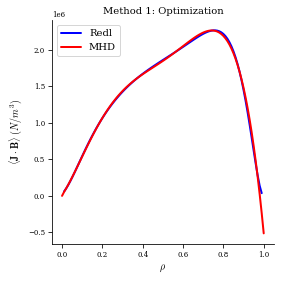

In [13]:
fig, ax = plot_1d(eq1, "<J*B> Redl", linecolor="b", lw=2, label="Redl")
fig, ax = plot_1d(eq1, "<J*B>", linecolor="r", lw=2, label="MHD", ax=ax)
ax.legend(loc="best")
ax.set_title("Method 1: Optimization");

### 2. Iterative Solves

In this method, we iteratively solve the equilibrium with updated guesses for the current profile. 
The current profile is computed such that the parallel current is consistent with the Redl formula, according to Equation C3 in [Landreman & Catto (2012)](https://doi.org/10.1063/1.3693187). 
This is the same approach as STELLOPT VBOOT with SFINCS, and it usually converges in only a few iterations. 

In [14]:
eq2 = eq0.copy()
fam2 = EquilibriaFamily(eq2)

In [15]:
niters = 3
for k in range(niters):
    eq2 = eq2.copy()
    # compute new guess for the current profile, consistent with Redl formula
    data = eq2.compute("current Redl", grid)
    current = grid.compress(data["current Redl"])
    rho = grid.compress(data["rho"])
    # fit the current profile to a power series, with c_0=c_1=0
    XX = np.fliplr(np.vander(rho, eq2.L + 1)[:, :-2])
    eq2.c_l = np.pad(np.linalg.lstsq(XX, current, rcond=None)[0], (2, 0))
    # re-solve the equilibrium
    eq2, _ = eq2.solve(objective="force", optimizer="lsq-exact", verbose=3)
    fam2.append(eq2)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 49.6 ms
Timer: Objective build = 67.5 ms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed current
Building objective: fixed electron density
Building objective: fixed electron temperature
Building objective: fixed ion temperature
Building objective: fixed atomic number
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 213 ms
Timer: LinearConstraintProjection build = 1.89 sec
Number of parameters: 856
Number of objectives: 5346
Timer: Initializing the optimization = 2.18 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1  

We can plot the current profile at each iteration to visualize how it changed: 

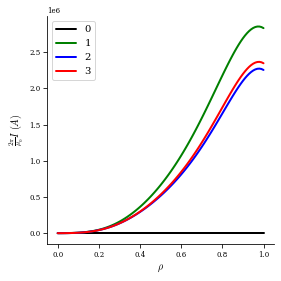

In [16]:
fig, ax = plot_1d(fam2[0], "current", linecolor="k", lw=2, label="0")
fig, ax = plot_1d(fam2[1], "current", linecolor="g", lw=2, label="1", ax=ax)
fig, ax = plot_1d(fam2[2], "current", linecolor="b", lw=2, label="2", ax=ax)
fig, ax = plot_1d(fam2[3], "current", linecolor="r", lw=2, label="3", ax=ax)
ax.legend(loc="best");

With this method the MHD equilibrium also has very good agreement with the Redl formula. 

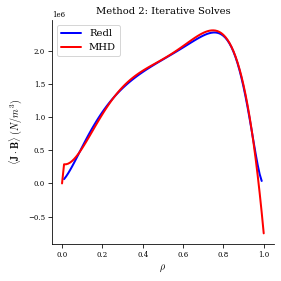

In [17]:
fig, ax = plot_1d(eq2, "<J*B> Redl", linecolor="b", lw=2, label="Redl")
fig, ax = plot_1d(eq2, "<J*B>", linecolor="r", lw=2, label="MHD", ax=ax)
ax.legend(loc="best")
ax.set_title("Method 2: Iterative Solves");

### Comparison

Even though both methods give good self-consistency for the bootstrap current, they do result in slightly different coefficients for the current profile: 

In [18]:
print(eq1.c_l)
print(eq2.c_l)

[ 0.00000000e+00  0.00000000e+00 -4.66433725e+03  4.08231235e+06  1.57041990e+07 -6.55435420e+07  9.56800293e+07 -5.79958101e+07  1.04084081e+07]
[ 0.00000000e+00  0.00000000e+00  4.45132089e+05 -1.55375762e+06  4.20367536e+07 -1.24732650e+08  1.64815797e+08 -9.79230045e+07  1.92576479e+07]


In this example, the first method of optimization gave better self-consistency but was noticeably slower than the second method of iterative solves. 

## Using Spline Profiles

We can also use splines to describe the current profile, which works with both methods above. However, the treatment of the profile for the iterative method differs slightly, which we show below.

In [37]:
import jax

jax.clear_caches()

In [41]:
eq1_spline = eq0.copy()
rho = np.linspace(0, 1, 25)
eq1_spline.current = SplineProfile(np.zeros_like(rho), rho, "cubic")


grid = LinearGrid(
    M=eq0.M_grid,
    N=eq0.N_grid,
    NFP=eq0.NFP,
    sym=eq0.sym,
    rho=np.linspace(1 / eq0.L_grid, 1, eq0.L_grid) - 1 / (2 * eq0.L_grid),
)

L_grid = 25

grid = LinearGrid(
    M=eq0.M_grid,
    N=eq0.N_grid,
    NFP=eq0.NFP,
    sym=eq0.sym,
    rho=np.linspace(1 / L_grid, 1, L_grid) - 1 / (2 * L_grid),
)

In [ ]:
objective = ObjectiveFunction(
    BootstrapRedlConsistency(
        eq=eq1_spline, grid=grid, helicity=(1, 0), degree=4
    )  # ,deriv_mode="fwd", degree=4), jac_chunk_size=1, deriv_mode="batched"
)
constraints = (
    FixAtomicNumber(eq=eq1_spline),
    FixBoundaryR(eq=eq1_spline),
    FixBoundaryZ(eq=eq1_spline),
    FixCurrent(
        eq=eq1_spline, indices=[0]
    ),  # fix the rho=0 knot so I=0 on axis is enforced
    FixElectronDensity(eq=eq1_spline),
    FixElectronTemperature(eq=eq1_spline),
    FixIonTemperature(eq=eq1_spline),
    FixPsi(eq=eq1_spline),
    ForceBalance(eq=eq1_spline),
)
eq1_spline, _ = eq1_spline.optimize(
    objective=objective,
    constraints=constraints,
    optimizer="proximal-lsq-exact",
    maxiter=20,
    ftol=1e-4,
    verbose=3,
)

Building objective: Bootstrap current self-consistency (Redl)


Precomputing transforms
Timer: Precomputing transforms = 1.02 sec
Timer: Objective build = 1.55 sec
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 64.4 ms
Timer: Objective build = 113 ms
Timer: Objective build = 1.29 ms
Timer: Eq Update LinearConstraintProjection build = 2.68 sec
Timer: Proximal projection build = 4.94 sec
Building objective: fixed atomic number
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed current
Building objective: fixed electron density
Building objective: fixed electron temperature
Building objective: fixed ion temperature
Building objective: fixed Psi
Timer: Objective build = 176 ms
Timer: LinearConstraintProjection build = 2.63 sec
Number of parameters: 24
Number of objectives: 25
Timer: Initializing the optimization = 7.80 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0             

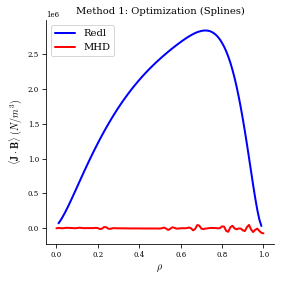

In [ ]:
fig, ax = plot_1d(eq1_spline, "<J*B> Redl", linecolor="b", lw=2, label="Redl")
fig, ax = plot_1d(eq1_spline, "<J*B>", linecolor="r", lw=2, label="MHD", ax=ax)
ax.legend(loc="best")
ax.set_title("Method 1: Optimization (Splines)");

In [ ]:
eq2_spline = eq0.copy()
fam2 = EquilibriaFamily(eq2_spline)
rho = np.linspace(0, 1, 25)
eq2_spline.current = SplineProfile(np.zeros_like(rho), rho)

In [ ]:
niters = 3
fit_degree = 9
for k in range(niters):
    eq2_spline = eq2_spline.copy()
    # compute new guess for the current profile, consistent with Redl formula
    data = eq2_spline.compute("current Redl", grid)
    current = grid.compress(data["current Redl"])
    rho = grid.compress(data["rho"])
    # fit the current profile to a power series, with c_0=c_1=0
    XX = np.fliplr(np.vander(rho, fit_degree)[:, :-2])
    eq2_spline.c_l = np.pad(np.linalg.lstsq(XX, current, rcond=None)[0], (2, 0))
    # re-solve the equilibrium
    eq2_spline, _ = eq2_spline.solve(
        objective="force", optimizer="lsq-exact", verbose=3
    )
    fam2.append(eq2_spline)

ValueError: [31mparams should have the same size as the knots, got 9 values for 10 knots[0m

We can plot the current profile at each iteration to visualize how it changed: 

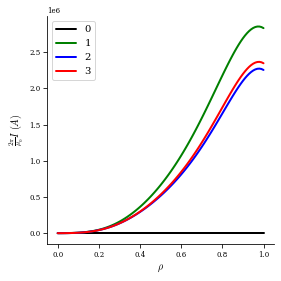

In [ ]:
fig, ax = plot_1d(fam2[0], "current", linecolor="k", lw=2, label="0")
fig, ax = plot_1d(fam2[1], "current", linecolor="g", lw=2, label="1", ax=ax)
fig, ax = plot_1d(fam2[2], "current", linecolor="b", lw=2, label="2", ax=ax)
fig, ax = plot_1d(fam2[3], "current", linecolor="r", lw=2, label="3", ax=ax)
ax.legend(loc="best");

With this method the MHD equilibrium also has very good agreement with the Redl formula. 

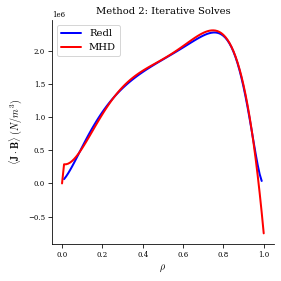

In [ ]:
fig, ax = plot_1d(eq2, "<J*B> Redl", linecolor="b", lw=2, label="Redl")
fig, ax = plot_1d(eq2, "<J*B>", linecolor="r", lw=2, label="MHD", ax=ax)
ax.legend(loc="best")
ax.set_title("Method 2: Iterative Solves");